## 5.다층 퍼셉트론

앞서 구현한 단층 퍼셉트론은 비선형문제를 해결할 수 없다는 한계가 존재한다.   
이를 다층으로 구성하면 문제를 해결할 수 있다. 

In [2]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt


In [33]:
x = torch.FloatTensor(range(5)).unsqueeze(1) # input
y = 2*x + torch.rand(5,1) # ground truth / x에서 2배하고 0~1사잇값 더한거 

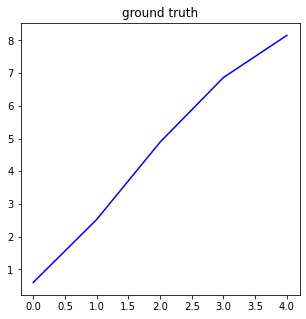

In [37]:
plt.figure(figsize = (5,5))
plt.plot(x,y,'-b')
plt.title('ground truth')
plt.show()

In [32]:
print(x)
print(y)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
tensor([[0.9454],
        [2.3258],
        [4.4722],
        [6.2096],
        [8.2923]])


In [15]:
class LinearRegressor(nn.Module): # nn.Module을 상속받는 클래스를 생성 
    def __init__(self): # 토기화 함수를 작성하여 nn.Module의 init을 실행시키고 나머지 필요부분을 실행 
        super().__init__()
        self.fc = nn.Linear(1,1,bias = True) # (입력변수, 출력변수, bias) / nn.Linear를 통해 선형변환을 수행 

    def forward(self, x): # 
        y = self.fc(x)
        return y 

In [27]:
model = LinearRegressor() # 모델 지정 
learning_rate = 1e-3 # lr 지정 
criterion = nn.MSELoss() # loss function 지정 
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)  # lr과 model param을 이용하여 optim 지정 


In [28]:
loss_stack = []
for epoch in range(1001):
    optimizer.zero_grad()

    y_hat = model(x)
    loss = criterion(y_hat,y)
    loss.backward()
    optimizer.step()
    loss_stack.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}:{loss.item()}')


Epoch 0:11.648706436157227
Epoch 100:0.820004940032959
Epoch 200:0.09025335311889648
Epoch 300:0.04017571732401848
Epoch 400:0.035942722111940384
Epoch 500:0.034891776740550995
Epoch 600:0.03414120897650719
Epoch 700:0.033487312495708466
Epoch 800:0.0329078808426857
Epoch 900:0.03239370509982109
Epoch 1000:0.03193743899464607


In [29]:
with torch.no_grad():
    y_hat = model(x)
    

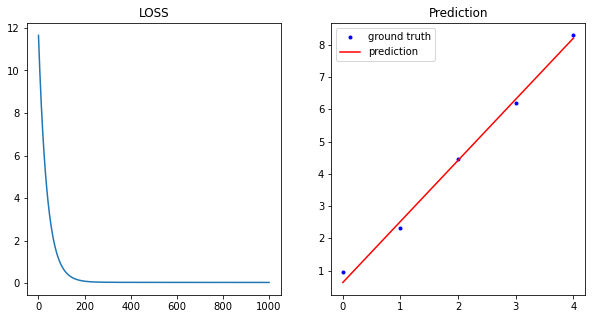

In [31]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("LOSS")
plt.subplot(122)
plt.plot(x,y,'.b')
plt.plot(x,y_hat,'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()

지금까지의 내용이 단층 퍼셉트론(nn.Linear()가 1개 들어감)을 이용하여 선형회귀를 실행한 코드이다.   
다음으로 집값 예측을 위해 다층 퍼셉트론을 구현해 본다.  

집값데이터는 위에서 직접 만든 데이터처럼 단순히 선형으로써 구분지을 수 있는것이 아니기에(위 그래프에 비해보자면 빨간선이 곡선임)/(위에서 만들어진 x(가중치)는 빨간선의 기울기임)
퍼셉트론을 여러개 이용해야 한다. 


In [141]:
import pandas as pd # csv형태의 데이터셋을 다루기 위해 
import numpy as np # 
from sklearn.model_selection import train_test_split
import torch
from torch import nn,optim 
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [142]:
df = pd.read_csv('./data/reg.csv',index_col = [0]) # csv파일을 읽어오고 index_col을 사용하여 열의 인덱스(key값)을 0번째 열로 사용하게 한다. 

In [143]:
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.028702,0.019528,0.455716,0.097575,0.576859,0.588769,0.654701,0.188444,0.007595,0.165409,0.736795,0.982923,0.219891,0.386667
502,0.034217,0.009498,0.490485,0.372934,0.532351,0.580505,0.750547,0.143776,0.051186,0.166428,0.867950,0.995114,0.207453,0.346667
503,0.035352,0.021495,0.423918,0.397988,0.349407,0.610529,0.907637,0.087385,0.083448,0.164870,0.782704,0.995791,0.094044,0.420000
504,0.026182,0.028603,0.443442,0.509663,0.229142,0.667841,0.867135,0.236241,0.016177,0.167554,0.749186,0.986855,0.107399,0.377778


In [144]:
X = df.drop('Price',axis=1).to_numpy() # 두 번째 차원(열방향)에서 Price열을 삭제하고 numpy로 변환하여 반환 -> train 데이터 
X.shape

(506, 13)

In [145]:
Y = df['Price'].to_numpy().reshape(-1,1) # Price 열만 가져와서 반환 (shape를 맞추기위해 reshape사용 ) 
Y.shape

(506, 1)

In [146]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.5)

In [147]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(253, 13)
(253, 13)
(253, 1)
(253, 1)


마련한 데이터셋으로 DataLoader를 생성한다. 


In [154]:
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index],self.y_data[index]

    def __len__(self):
        return self.len

trainsets = TensorData(X_train,Y_train)
trainloader = torch.utils.data.DataLoader(trainsets,batch_size = 32, shuffle = True)
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets,batch_size = 32, shuffle = False)

데이터셋을 마련했으니 모델을 구축한다. 


In [155]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,1)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x

         
    

In [156]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay = 1e-7)

In [157]:
# for i in model.parameters():
#     print(i.shape)

In [158]:
loss_stack = []
n = len(trainloader) # batch 의 갯수 -> 매 epoch의 손실함수의 평균값을 구하기 위해 사용 

for epoch in range(400):
    running_loss = 0.0 # 평균을 계산하기위해 0으로 초기화 

    for data in trainloader:
        inputs,outputs = data
        # print(inputs.shape)
        # print(outputs.shape)
        optimizer.zero_grad()
        y_hat = model(inputs)
        loss = criterion(y_hat,outputs)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()

    loss_stack.append(running_loss/n)
    


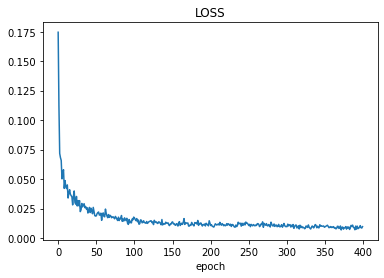

In [159]:
plt.plot(loss_stack)
plt.title('LOSS')
plt.xlabel("epoch")
plt.show()

모델 평가

In [ ]:
def evaluation(dataloader):
    predictions = torch.tensor